### Локализация объектов

#### Подготовим импорты

Из нового: 
1. `xml.etree.ElementTree` – с помощью него будем разбирать XML-файлы и доставать координаты bbox'ов 
2. `torchmetrics.functional.detection.iou` – чтобы вручную не считать IoU

In [1]:
import os
import xml.etree.ElementTree as ET
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchutils as tu
import torchvision.transforms as T
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.detection.iou import intersection_over_union
import torch.optim as optim
from torchvision import models

#### XML-файлы

In [2]:
annotation = ET.parse('../cv_yolo/Veg/loc_train/cucumber_1.xml')

In [3]:
print(annotation)

In [4]:
annotation.find('object').find('bndbox').find('ymin').text

'42'

#### Подготовим датасет

Он принимает на вход в конструктор 3 переменные: 
* `root_dir` – путь к обучающим/валидационным файлам (включая соответствующие xml-файлы)
* `image_size` – сразу определимся с размером картинок (у нас 227х227)
* `transform` – какие преобразования использовать для картинок (как минимум `ToTensor`, но обучающие будем аугментировать)

In [5]:
# type: ignore
class CustomDataset(Dataset):
    def __init__(
            self, 
            root_dir: str, 
            image_size: int = 227, 
            transform: T.Compose = T.Compose([])
            ):
        self.image_size = image_size
        self.root_dir: str = root_dir
        self.transform = transform
        # создаем два списка: с картинками и xml
        self.img_paths = sorted(glob(f'{self.root_dir}/*.jpg'))
        self.xml_paths = sorted(glob(f'{self.root_dir}/*.xml'))

        # вспомогательные словари, чтобы из названий классов получать индексы
        self.cls2ix = {
            'cucumber' : 0, 
            'eggplant' : 1, 
            'mushroom' : 2
            }
        # а здесь наоборот
        self.ix2cls = {v: k for k, v in self.cls2ix.items()}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # по индексу находим в списке файлов аннотацию
        annotation = ET.parse(self.xml_paths[idx]) 
        # забираем название файла с картинкой
        filename = annotation.find('filename').text
        # открываем картинку
        image = Image.open(os.path.join(self.root_dir, filename)) 
        # преобразуем
        if self.transform:
            image = self.transform(image)
        # получаем название класса
        label = annotation.find('object').find('name').text 
        # преобразуем в индекс
        label = self.cls2ix[label]
        # получаем координаты bbox'a
        xmin = int(annotation.find('object').find('bndbox').find('xmin').text)
        ymin = int(annotation.find('object').find('bndbox').find('ymin').text)
        xmax = int(annotation.find('object').find('bndbox').find('xmax').text)
        ymax = int(annotation.find('object').find('bndbox').find('ymax').text)
        # конвертируем в тензор и преобразуем в диапазон [0-1]
        bbox = torch.Tensor((xmin, ymin, xmax, ymax)) / self.image_size
        return torch.tensor(label), bbox, image, filename

In [6]:
train_aug = T.Compose(
    [   
        
        T.GaussianBlur(kernel_size=(5, 9), sigma=(0.3, 5.)),
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
valid_aug = T.Compose(
    [   
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
train_dataset = CustomDataset(root_dir='../cv_yolo/Veg/loc_train', image_size=227, transform=train_aug)
valid_dataset = CustomDataset(root_dir='../cv_yolo/Veg/loc_valid', image_size=227, transform=valid_aug)

In [7]:
print(len(train_dataset))
print(len(valid_dataset))

148
38


In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
batch = next(iter(train_loader))
batch

[tensor([2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 2,
         0, 1, 0, 1, 2, 0, 0, 1]),
 tensor([[0.4493, 0.1189, 0.9119, 0.7401],
         [0.3392, 0.3480, 0.6344, 0.9383],
         [0.1454, 0.2952, 0.8414, 0.8326],
         [0.2247, 0.2159, 0.8811, 0.8722],
         [0.1057, 0.2026, 0.9031, 0.9339],
         [0.2159, 0.1630, 0.8458, 0.7577],
         [0.4934, 0.2423, 0.8943, 0.8150],
         [0.0793, 0.3436, 0.8370, 0.7004],
         [0.1101, 0.0617, 0.8767, 0.5859],
         [0.1938, 0.2907, 0.6828, 0.7357],
         [0.1233, 0.3084, 0.7974, 0.7797],
         [0.0837, 0.1850, 0.9383, 0.8194],
         [0.0352, 0.1674, 0.9648, 0.7930],
         [0.2643, 0.1938, 0.7181, 0.8634],
         [0.2423, 0.1322, 0.7357, 0.9339],
         [0.1894, 0.0881, 0.8678, 0.8018],
         [0.3436, 0.0749, 0.6740, 0.9559],
         [0.1410, 0.3260, 0.8811, 0.5815],
         [0.0573, 0.5683, 0.8634, 0.7489],
         [0.1850, 0.1057, 0.7930, 0.9383],
         [0.1410, 0.1894

### Создайте модель и обучите её для решения задачи локализации

В качестве экстрактора признаков будем использовать предобученный ResNet18, но отрежем последние два слоя: пулинг и полносвязный

In [11]:
class ResNet18Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Model, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes + 4)  # +4 для координат бокса

    def forward(self, x):
        x = self.resnet(x)
        class_logits = x[:, :3]  # предсказание классов (первые 3 выхода)
        bbox_coords = x[:, 3:]    # предсказание координат бокса (последние 4 выхода)
        return class_logits, bbox_coords

# определяем количество классов
num_classes = len(train_dataset.cls2ix)

# объявляем модель
model = ResNet18Model(num_classes=num_classes)

# перемещаем модель на видеокарту
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# определяем функцию потерь и оптимизатор
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# для хранения метрик
train_losses = []
val_losses = []
train_class_losses = []
val_class_losses = []
train_bbox_losses = []
val_bbox_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []

# функция для расчета IoU
def calculate_iou(predicted_bboxes, true_bboxes):
    # простой расчет IoU
    x1 = torch.max(predicted_bboxes[:, 0], true_bboxes[:, 0])
    y1 = torch.max(predicted_bboxes[:, 1], true_bboxes[:, 1])
    x2 = torch.min(predicted_bboxes[:, 2], true_bboxes[:, 2])
    y2 = torch.min(predicted_bboxes[:, 3], true_bboxes[:, 3])

    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    area_pred = (predicted_bboxes[:, 2] - predicted_bboxes[:, 0]) * (predicted_bboxes[:, 3] - predicted_bboxes[:, 1])
    area_true = (true_bboxes[:, 2] - true_bboxes[:, 0]) * (true_bboxes[:, 3] - true_bboxes[:, 1])

    union = area_pred + area_true - intersection
    iou = intersection / union
    return iou

# функция обучения модели
def train_model(model, train_loader, valid_loader, criterion_class, criterion_bbox, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_class_loss = 0.0
        running_bbox_loss = 0.0
        correct = 0
        total = 0
        all_train_ious = []

        for labels, bboxes, images, _ in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            # обнуляем градиенты
            optimizer.zero_grad()

            # прямой проход
            class_logits, predicted_bboxes = model(images)

            # вычисляем потери
            loss_class = criterion_class(class_logits, labels)
            loss_bbox = criterion_bbox(predicted_bboxes, bboxes)
            loss = loss_class + loss_bbox
            
            # обратный проход
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_class_loss += loss_class.item()
            running_bbox_loss += loss_bbox.item()

            # вычисляем точность
            _, predicted = torch.max(class_logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # вычисляем IoU
            iou = calculate_iou(predicted_bboxes, bboxes).mean().item()
            all_train_ious.append(iou)

        epoch_loss = running_loss / len(train_loader)
        epoch_class_loss = running_class_loss / len(train_loader)
        epoch_bbox_loss = running_bbox_loss / len(train_loader)
        accuracy = correct / total
        
        # сохраняем метрики
        train_losses.append(epoch_loss)
        train_class_losses.append(epoch_class_loss)
        train_bbox_losses.append(epoch_bbox_loss)
        train_accuracies.append(accuracy)
        train_ious.append(sum(all_train_ious) / len(all_train_ious))

        print(f'Epoch [{epoch+1}/{num_epochs}], 'f'Train Loss: {epoch_loss:.4f}, Train Class Loss: {epoch_class_loss:.4f}, 'f'Train BBox Loss: {epoch_bbox_loss:.4f}, Train Accuracy: {accuracy:.4f}, 'f'Train IoU: {train_ious[-1]:.4f}')

        # валидация после каждой эпохи
        val_loss, val_class_loss, val_bbox_loss, val_accuracy, val_iou = validate_model(model, valid_loader, criterion_class, criterion_bbox)
        val_losses.append(val_loss)
        val_class_losses.append(val_class_loss)
        val_bbox_losses.append(val_bbox_loss)
        val_accuracies.append(val_accuracy)
        val_ious.append(val_iou)

    # визуализация метрик
    plotmetrics()

def validate_model(model, valid_loader, criterion_class, criterion_bbox):
    model.eval()
    running_loss = 0.0
    running_class_loss = 0.0
    running_bbox_loss = 0.0
    correct = 0
    total = 0
    all_val_ious = []

    with torch.no_grad():
        for data in valid_loader:  # получаем данные как единое значение
            if len(data) == 4:  # Если возвращается 4 значения
                labels, bboxes, images, _ = data
            elif len(data) == 3:  # Если возвращается 3 значения
                labels, bboxes, images = data
            else:
                raise ValueError(f'Unexpected number of values returned by valid_loader: {len(data)}')

            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            class_logits, predicted_bboxes = model(images)
            loss_class = criterion_class(class_logits, labels)
            loss_bbox = criterion_bbox(predicted_bboxes, bboxes)
            loss = loss_class + loss_bbox
            
            running_loss += loss.item()
            running_class_loss += loss_class.item()
            running_bbox_loss += loss_bbox.item()

            # вычисляем точность
            _, predicted = torch.max(class_logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # вычисляем IoU
            iou = calculate_iou(predicted_bboxes, bboxes).mean().item()
            all_val_ious.append(iou)

    val_loss = running_loss / len(valid_loader)
    val_class_loss = running_class_loss / len(valid_loader)
    val_bbox_loss = running_bbox_loss / len(valid_loader)
    val_accuracy = correct / total
    val_iou = sum(all_val_ious) / len(all_val_ious)

    print(f'Validation Loss: {val_loss:.4f}, Validation Class Loss: {val_class_loss:.4f}, 'f'Validation BBox Loss: {val_bbox_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, 'f'Validation IoU: {val_iou:.4f}')

    return val_loss, val_class_loss, val_bbox_loss, val_accuracy, val_iou

def plotmetrics():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 10))

    # losses
    plt.subplot(3, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # classification Loss
    plt.subplot(3, 2, 2)
    plt.plot(epochs, train_class_losses, label='Training Class Loss')
    plt.plot(epochs, val_class_losses, label='Validation Class Loss')
    plt.title('Classification Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # bbox Loss
    plt.subplot(3, 2, 3)
    plt.plot(epochs, train_bbox_losses, label='Training BBox Loss')
    plt.plot(epochs, val_bbox_losses, label='Validation BBox Loss')
    plt.title('Bounding Box Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy
    plt.subplot(3, 2, 4)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # iou
    plt.subplot(3, 2, 5)
    plt.plot(epochs, train_ious, label='Training IoU')
    plt.plot(epochs, val_ious, label='Validation IoU')
    plt.title('IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch [1/100], Train Loss: 0.7830, Train Class Loss: 0.3008, Train BBox Loss: 0.4822, Train Accuracy: 0.8581, Train IoU: 0.0689
Validation Loss: 7.9411, Validation Class Loss: 6.9257, Validation BBox Loss: 1.0153, Validation Accuracy: 0.3684, Validation IoU: 0.0444
Epoch [2/100], Train Loss: 0.1466, Train Class Loss: 0.0268, Train BBox Loss: 0.1198, Train Accuracy: 0.9932, Train IoU: 0.2369
Validation Loss: 29.4688, Validation Class Loss: 19.6421, Validation BBox Loss: 9.8267, Validation Accuracy: 0.3421, Validation IoU: 0.0127
Epoch [3/100], Train Loss: 0.0466, Train Class Loss: 0.0117, Train BBox Loss: 0.0348, Train Accuracy: 1.0000, Train IoU: 0.4205
Validation Loss: 4.2149, Validation Class Loss: 3.5154, Validation BBox Loss: 0.6994, Validation Accuracy: 0.5000, Validation IoU: 0.0216
Epoch [4/100], Train Loss: 0.0362, Train Class Loss: 0.0107, Train BBox Loss: 0.0256, Train Accuracy: 1.0000, Train IoU: 0.4501
Validation Loss: 0.7311, Validation Class Loss: 0.6694, Validation BBox 

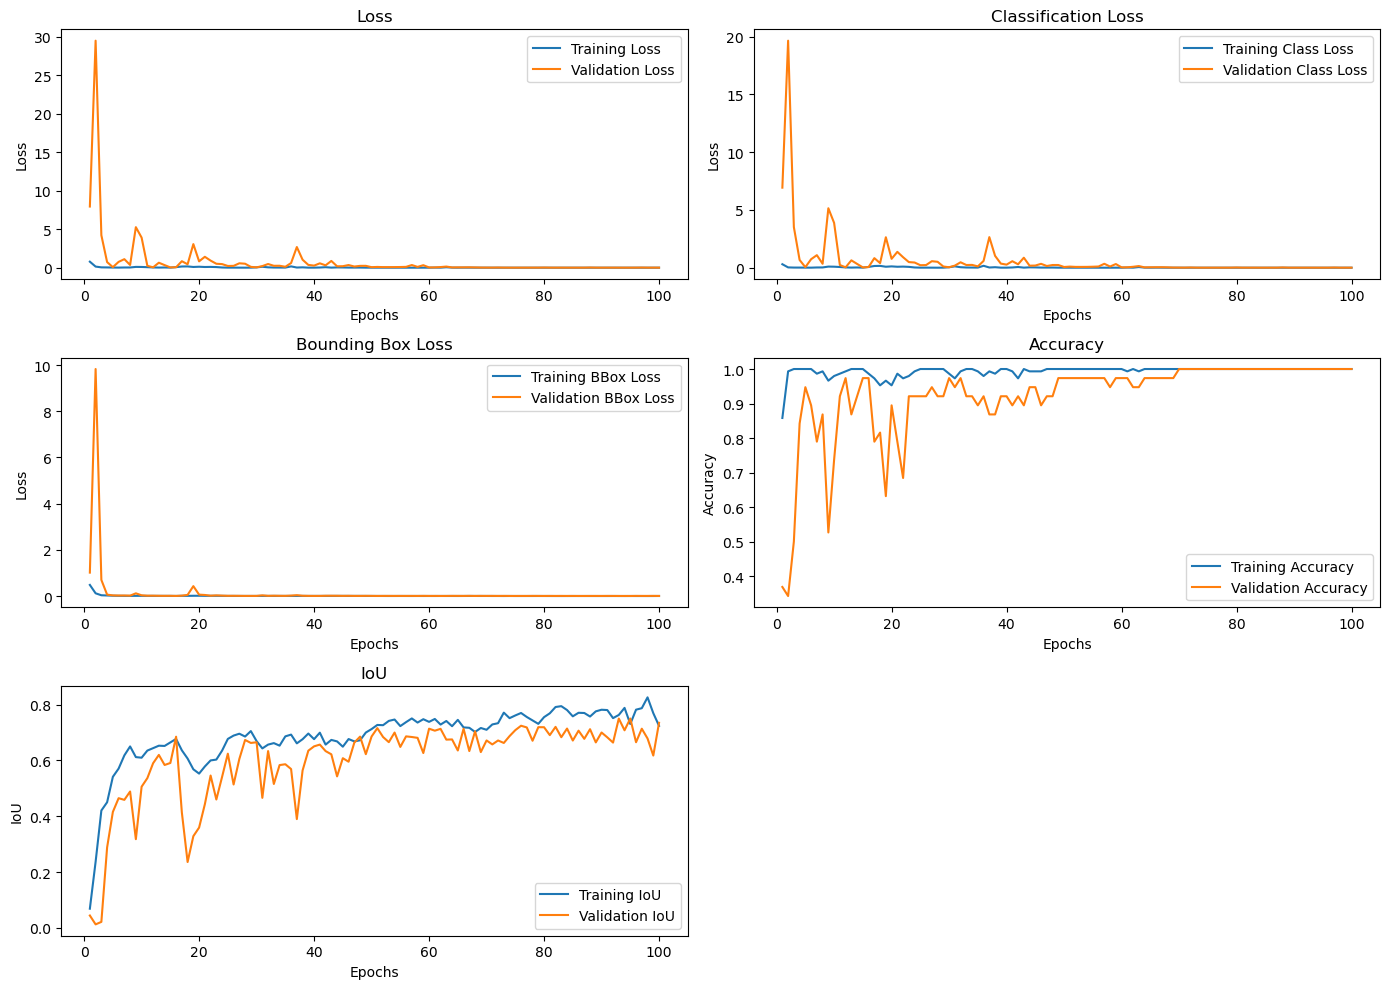

In [12]:
# обучаем модель
train_model(model, train_loader, valid_loader, criterion_class, criterion_bbox, optimizer, num_epochs=100)

In [13]:
torch.save(model.state_dict(), 'model.pth')